<a href="https://colab.research.google.com/github/olivier-sutter/Personal-Projects/blob/master/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Dream with PyTorch

## Imports and useful functions

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!pip3 install torch torchvision
!pip install imageio

import numpy as np
import torch
from torch.autograd import Variable
from torch.optim import SGD
from torchvision import models, transforms
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import PIL

import imageio

import time

import scipy.ndimage as ndimage

import random

from torch import nn

%matplotlib inline

import scipy.ndimage as nd
from IPython.display import clear_output, Image, display
from io import BytesIO

!pip install pillow==4.1.1

# workaround 
from PIL import Image, ImageFilter, ImageChops
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

    100% |████████████████████████████████| 591.8MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61494000 @  0x7f9e06b542a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 20.7MB/s 
    100% |████████████████████████████████| 2.0MB 7.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.
    100% |████████████████████████████████| 5.7MB 6.9MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    plt.imshow(a)
    
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).show()
    
def showtensor(a):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    showarray(inp)
    clear_output(wait=True)

def plot_images(im, titles=None):
    plt.figure(figsize=(30, 20))
    
    for i in range(len(im)):
        plt.subplot(10 / 5 + 1, 5, i + 1)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(im[i])
        
    plt.pause(0.001)

def init_image(size=(400, 400, 3)):
    img = PIL.Image.fromarray(np.uint8(np.full(size, 150)))
    img = PIL.Image.fromarray(np.uint8(np.random.uniform(150, 180, size)))
    img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def load_image(path, resize=False, size=None):
    img = PIL.Image.open(path)
    
    if size is not None:
        img.thumbnail(size, PIL.Image.ANTIALIAS)
        
    if resize:
        img_tensor = normalise_resize(img).unsqueeze(0)
    else:
        img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np
  
def tensor_to_img(t):
    a = t.numpy()
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    inp = np.uint8(np.clip(inp, 0, 255))
    return PIL.Image.fromarray(inp)

def image_to_variable(image, requires_grad=False, cuda=False):
    if cuda:
        image = Variable(image.cuda(), requires_grad=requires_grad)
    else:
        image = Variable(image, requires_grad=requires_grad)
    return image

## Pretrained VGG16

In [0]:
normalise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

normalise_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### If you want to use VGG16

In [5]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:21<00:00, 25285817.32it/s]


### If you want to use DenseNet121

In [188]:
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


### If you want to use ResNet152 

In [0]:
model = models.resnet152(pretrained=True)

### If you want to use ResNet152 trained on flowers

In [196]:
model = models.resnet152(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 102),
                                   nn.LogSoftmax(dim=1))


# Send the model to GPU
model = model.cuda()

# For future save / load
filename='/content/drive/My Drive/MyColab/Final_Project/seriouscheckpoint.pth'

checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model.load_state_dict(checkpoint['state_dict'])
model.class_to_idx = checkpoint['mapping']

print("Best accuracy : {}".format(best_acc))

Best accuracy : 0.9951100244498777


## Octaver function

In [0]:
def octaver_fn(model, base_img, step_fn, octave_n=6, octave_scale=1.4, iter_n=10, **step_args):
    octaves = [base_img]
    
    for i in range(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)
        
        src = octave_base + detail
        
        for i in range(iter_n):
            src = step_fn(model, src, **step_args)

        detail = src.numpy() - octave_base

    return src

## Filter Visualization

In [0]:
def filter_step(model, img, layer_index, filter_index, step_size=5, display=True, use_L2=False):
    global use_gpu
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    model.zero_grad()
    
    img_var = image_to_variable(torch.Tensor(img), requires_grad=True, cuda=use_gpu)
    optimizer = SGD([img_var], lr=step_size, weight_decay=1e-4)
    
    x = img_var
    for index, layer in enumerate(model.features):
        x = layer(x)
        if index == layer_index:
            break

    output = x[0, filter_index]
    loss = output.norm() #torch.mean(output)
    loss.backward()
    
    if use_L2:
        #L2 normalization on gradients
        mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2) + 1e-5])
        if use_gpu:
            mean_square = mean_square.cuda()
        img_var.grad.data /= torch.sqrt(mean_square)
        img_var.data.add_(img_var.grad.data * step_size)
    else:
        optimizer.step()
        
    result = img_var.data.cpu().numpy()
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    
    if display:
        showtensor(result)
    
    return torch.Tensor(result)

def visualize_filter(model, base_img, layer_index, filter_index, 
                     octave_n=6, octave_scale=1.4, iter_n=10, 
                     step_size=5, display=True, use_L2=False):
    
    return octaver_fn(
                model, base_img, step_fn=filter_step, 
                octave_n=octave_n, octave_scale=octave_scale, 
                iter_n=iter_n, layer_index=layer_index, 
                filter_index=filter_index, step_size=step_size, 
                display=display, use_L2=use_L2
            )

In [0]:
def show_layer(layer_num, filter_start=10, filter_end=20, step_size=7, use_L2=False):
    filters = []
    titles = []
    
    _, _, img_np = init_image(size=(600, 600, 3))
    for i in range(filter_start, filter_end):
        title = "Layer {} Filter {}".format(layer_num , i)
        print(title)
        filter = visualize_filter(model, img_np, layer_num, filter_index=i, octave_n=2, iter_n=20, step_size=step_size, display=True, use_L2=use_L2)
        filter_img = tensor_to_img(filter)
        filter_img.save(title + ".jpg")
        filters.append(tensor_to_img(filter))
        titles.append(title) 
    
    plot_images(filters, titles)
    return filters, titles

## Deep Dream

In [0]:
def objective(dst, guide_features):
    if guide_features is None:
        return dst.data
    else:
        x = dst.data[0].cpu().numpy()
        y = guide_features.data[0].cpu().numpy()
        ch, w, h = x.shape
        x = x.reshape(ch, -1)
        y = y.reshape(ch, -1)
        A = x.T.dot(y)
        diff = y[:, A.argmax(1)]
        diff = torch.Tensor(np.array([diff.reshape(ch, w, h)])).cuda()
        return diff

In [0]:
def make_step(model, img, objective=objective, control=None, step_size=1.5, end=28, jitter=32):
    global use_gpu
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    
    img = np.roll(np.roll(img, ox, -1), oy, -2)
    tensor = torch.Tensor(img) 
    
    img_var = image_to_variable(tensor, requires_grad=True, cuda=use_gpu)
    model.zero_grad()
    
    if(model.__class__.__name__ == 'ResNet'):
      layers_list = [model.conv1,
               model.bn1,
               model.relu,
               model.maxpool]

      for i in range(len(model.layer1)):
        layers_list.append(model.layer1[i])

      for i in range(len(model.layer2)):
        layers_list.append(model.layer2[i])
  
      for i in range(len(model.layer3)):
        layers_list.append(model.layer3[i])

      for i in range(len(model.layer4)):
        layers_list.append(model.layer4[i])
      
      x = img_var
      for index, layer in enumerate(layers_list):
        x = layer(x)
        if index == end:
            break
    else:
      x = img_var
      for index, layer in enumerate(model.features.children()):
        x = layer(x)
        if index == end:
            break
    
    delta = objective(x, control)
    x.backward(delta)
    
    #L2 Regularization on gradients
    mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2)])
    if use_gpu:
        mean_square = mean_square.cuda()
    img_var.grad.data /= torch.sqrt(mean_square)
    img_var.data.add_(img_var.grad.data * step_size)
    
    result = img_var.data.cpu().numpy()
    result = np.roll(np.roll(result, -ox, -1), -oy, -2)
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    showtensor(result)
    
    return torch.Tensor(result)

def deepdream(model, base_img, octave_n=6, octave_scale=1.4, 
              iter_n=10, end=28, control=None, objective=objective, 
              step_size=1.5, jitter=32):
    
    return octaver_fn(
              model, base_img, step_fn=make_step, 
              octave_n=octave_n, octave_scale=octave_scale, 
              iter_n=iter_n, end=end, control=control,
              objective=objective, step_size=step_size, jitter=jitter
           )

## Tests on simple images

In [0]:
use_gpu = False
if torch.cuda.is_available():
    use_gpu = True

for param in model.parameters():
    param.requires_grad = False

if use_gpu:
    #print("Using CUDA")
    model.cuda()

(700, 496)


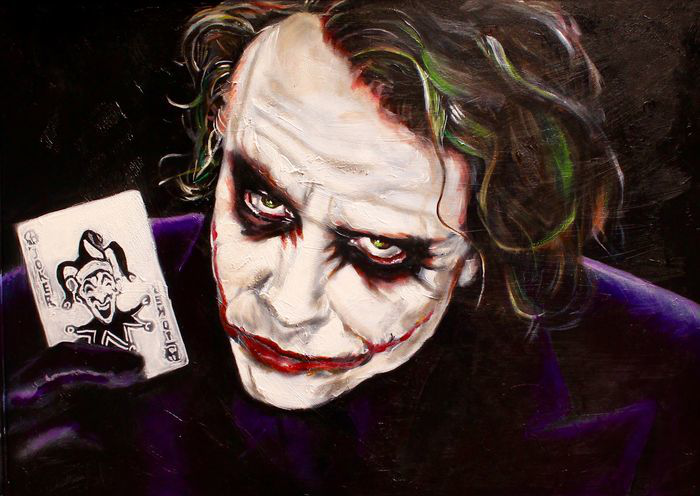

In [222]:
input_img, input_tensor, input_np = load_image('/content/drive/My Drive/MyColab/DeepDream V2/assets/joker.jpg', size=[1920, 1920])
print(input_img.size)
input_img

In [223]:
for i in range(54):
  print('Step {} / {}'.format(i+1,54))
  input_img, input_tensor, input_np = load_image('/content/drive/My Drive/MyColab/DeepDream V2/assets/joker.jpg', size=[1920, 1920])
  dream = deepdream(model, input_np, end=i, step_size=0.12, octave_n=9,iter_n=10,octave_scale=1.4,jitter=32)
  dream = tensor_to_img(dream)
  dream.save('/content/drive/My Drive/MyColab/DeepDream V2/resnet_results_pre/rn_lay_{}.jpg'.format(i))

Step 54 / 54


### Guiding the dream

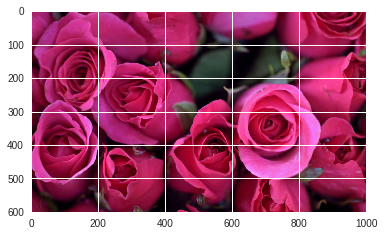

In [205]:
guide_img, guide_img_tensor, guide_img_np = load_image('/content/drive/My Drive/MyColab/DeepDream V2/assets/roses.jpeg', resize=True)
plt.imshow(guide_img)

end = 53

guide_features = image_to_variable(guide_img_tensor, cuda=use_gpu)

if(model.__class__.__name__ == 'ResNet'):
      layers_list = [model.conv1,
               model.bn1,
               model.relu,
               model.maxpool]

      for i in range(len(model.layer1)):
        layers_list.append(model.layer1[i])

      for i in range(len(model.layer2)):
        layers_list.append(model.layer2[i])
  
      for i in range(len(model.layer3)):
        layers_list.append(model.layer3[i])

      for i in range(len(model.layer4)):
        layers_list.append(model.layer4[i])
      
      for index, layer in enumerate(layers_list):
        guide_features = layer(guide_features)
        if index == end:
          break
else:
      for index, layer in enumerate(model.features.children()):
        guide_features = layer(guide_features)
        if index == end:
          break

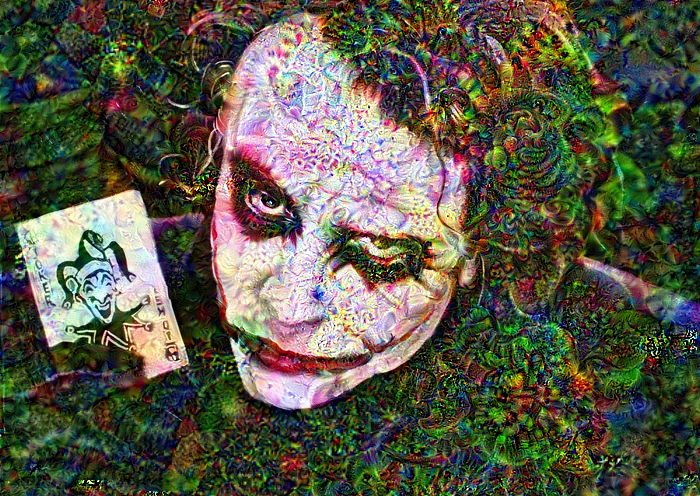

In [217]:
dream = deepdream(model, input_np, end=53, step_size=0.12, octave_n=9, control=guide_features)
dream = tensor_to_img(dream)
dream.save('/content/drive/My Drive/MyColab/DeepDream V2/tests/dream1603.jpg')
dream

## Trying on a GIF

In [219]:
!ls '/content/drive/My Drive/MyColab/DeepDream V2/assets/'

 art.gif	    dessin.jpg	      gwen.gif	   mirrors.gif	 smoke.gif
'backart (1).gif'   falling.gif       hearts.jpg   peintre.jpg
 chouchous.jpg	    girlreading.gif   joker.jpg    roses.jpeg


In [0]:
GIF_name = 'backart (1)'  #@param {type: "string"}


In [0]:
im = PIL.Image.open('/content/drive/My Drive/MyColab/DeepDream V2/assets/{}.gif'.format(GIF_name))

!rm '/content/drive/My Drive/MyColab/DeepDream V2/gif_tests/'

input_imgs, input_tensors, input_nps = [] , [] , []

acc = 0

try:
        while True:
      
            new_frame = im.convert('RGBA')
            new_frame.save('/content/drive/My Drive/MyColab/DeepDream V2/gif_tests/foo{}.jpg'.format(acc))
          
            input_img, input_tensor, input_np = load_image('/content/drive/My Drive/MyColab/DeepDream V2/gif_tests/foo{}.jpg'.format(acc), size=[1920, 1920])
            input_imgs.append(input_img)
            input_tensors.append(input_tensor)
            input_nps.append(input_np)
                 
            im.seek(im.tell()+1)
            
            acc += 1       
            
except EOFError:
        pass

In [0]:
params = [ [12 , 1.4 , 10, 19, None, objective, 0.03 , 64 ] ,
           [6 , 1.4 , 5, 19, None, objective,0.12 , 16 ] , 
           [6 , 1.4 , 10 , 21, None, objective,0.12 , 16] ,
           [6 , 1.4 , 5 , 17, None, objective,0.09 , 64] ,
           [6 , 1.4 , 20 , 21, None, objective,0.03 , 64] ,
           [12 , 1.4 , 15 , 28 , None, objective, 0.03 , 32]]

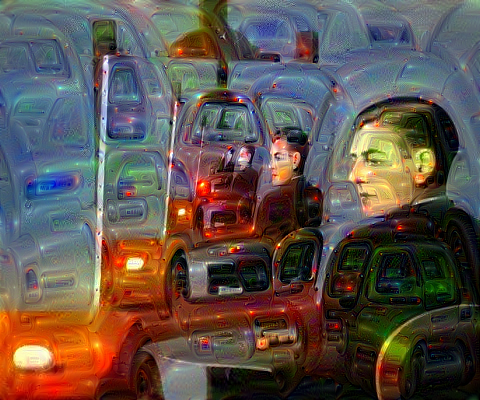

In [83]:
test_img, test_tensor, test_np = load_image('/content/drive/My Drive/MyColab/DeepDream V2/gif_tests/foo0.jpg', size=[1920, 1920])
print(test_img.size)
tensor_to_img(deepdream(model, test_np, *params[5]))

In [85]:
tot = len(input_nps)

nb_params = len(params)

for k in range(nb_params):
  
  start_time = time.time()
  images = []
  
  max_oct = params[k][0]
  max_step = params[k][-2]
  
  for i in range(tot):
    
    params[k][0] , params[k][-2] = (int(i*max_oct/tot) + 1) , i*max_step/tot
    
    print('Step {} / {} and test {} / {}'.format(i+1,tot,k+1,nb_params))
    print('Time elapsed : ',time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)), ' wrt estimated total time : ', time.strftime("%H:%M:%S", time.gmtime(tot/(i+1) * (time.time() - start_time))))
    dream = deepdream(model, input_nps[i], *params[k])
    dream = tensor_to_img(dream)
    dream.save('/content/drive/My Drive/MyColab/DeepDream V2/results/param_{}/frame{}.jpg'.format(k,i))
    images.append(np.array(dream))
    
  imageio.mimsave('/content/drive/My Drive/MyColab/DeepDream V2/results/param_{}/movie.gif'.format(k), images)

Step 50 / 50 and test 6 / 6
Time elapsed :  00:05:06  wrt estimated total time :  00:05:06


## Zooming test

In [0]:
input_img, input_tensor, input_np = load_image('/content/drive/My Drive/MyColab/DeepDream V2/assets/chouchous.jpg', size=[1920, 1920])
print(input_img.size)

N = 100

input_img.save('/content/drive/My Drive/MyColab/DeepDream V2/zoomin/frame0.jpg')

start_time = time.time()

h, w = input_img.size

for i in range(N):
  
    input_img, input_tensor, input_np = load_image('/content/drive/My Drive/MyColab/DeepDream V2/zoomin/frame{}.jpg'.format(i), size=[1920, 1920])
    
    s1 = 0.02
    s2 = 0.02
  
    print('Step : {} / {} '.format(i+1,N))
    
    pa = random.randint(0,nb_params-2)
    print(pa)
    
    dream = deepdream(model, input_np, *params[pa])
    dream = tensor_to_img(dream)
    
    dream = nd.affine_transform(np.array(dream), [1-s1,1-s2,1], [h*s1/2,w*s2/2,0], order=1)
    dream = Image.fromarray(np.uint8(dream))
    dream.save('/content/drive/My Drive/MyColab/DeepDream V2/zoomin/frame{}.jpg'.format(i+1))

    print(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

00:29:54
